## tranfer learning (전이 학습)
## transferlearning_001.ipynb 

#### 최소한의 노력으로 최대의 효과를 얻고자 하는 것이 목표
#### pypi.org에서 수많은 라이브러리가 있는 것처럼,
#### 분명히 다른 사람이 내가 하고자 하는 작업에 적합한 모델을 만드는데 시간을 보냈을꺼야!
#### 누군가가 딥러닝을 위해 모델을 이미 만들어서 존재한다.


[tensorflow hub](https://tfhub.dev/) : 기존 모델 구성 요소를 위한 저장소

#### 전이 학습을 사용하면, 원래 데이터의 10%만 사용하여 지금까지 최고의 모델이 얻은 것과 동일한 결과를 얻을 수 있다.

#### 우리가 지난주에 한 것처럼 1개의 클래스에 750개 정도의 이미지가 있어도 좋으련만... 
#### 이미지는 구하기도 어렵고, 구하는 시간도 오래 걸립니다. 이미지를 구할 때 귀찮으면 bias가 생길 수도 있다. (내가 좋은 결과를 얻고자 하는 이미지만 보려고 한다)
#### 시간은 없고, 돈도 없고, 이미지는 75개 정도만 있는데 결과를 빨리 얻고 싶은데...

In [2]:
!wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [3]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

# 10_food_classes_10_percent 라는 폴더가 생성됩니다.

In [5]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"{dirpath} 폴더에는 {len(dirnames)}개의 폴더와 {len(filenames)}개의 파일이 존재합니다.")

# 학습은 지난번보다 10%의 데이터로 하고, 테스트는 원래의 양과 같이 한다.

10_food_classes_10_percent 폴더에는 2개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent\test 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent\test\chicken_curry 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\chicken_wings 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\fried_rice 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\grilled_salmon 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\hamburger 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\ice_cream 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\pizza 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\ramen 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\steak 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\test\sushi 폴더에는 0개의 폴더와 250개의 파일이 존재합니다.
10_food_classes_10_percent\train 폴더에는 10개의 폴더와 0개의 파일이 존재합니다.
10_food_classes_10_percent\train\chicken_curry 폴더에는 0개의 폴더와 75개의 파일이 존재합니다.
10_food_classes_10_percent\t

In [8]:
# 데이터가 준비가 된 상태입니다.
# 데이터를 분석할 준비하기

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# data normalization
train_datagen = ImageDataGenerator(rescale = 1/255.) # 값을 0 ~ 1사이로 조정
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("학습 이미지 : ")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

print("테스트 이미지 : ")
test_data_10_percent = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)



학습 이미지 : 
Found 750 images belonging to 10 classes.
테스트 이미지 : 
Found 2500 images belonging to 10 classes.


### callback 설정 (모델이 학습하는 동안 실행하는 것)

#### 학습 중에 또는 학습 후에 수행할 모델에 기능을 더 추가해 주는 것!

#### TensorBoard를 사용!
#### 실험을 추적하고 여러 모델의 성능을 기록한 다음 tensorboard에서 시각적 방식으로
모델을 비교할 수 있습니다. 같은 데이터로 여러 모델의 결과를 비교하는데 유용합니다.

#### 모델 체크포인트 (Model Checkpointing) : 상황에 따라 학습을 중지하고 다시 돌아와서 계속 진행할 수 있도록 모델을 저장

#### 조기 중지 (Early Stopping) : 임의의 시간동안 모델 학습을 진행시키다가 모델이 개선된 것으로 판단이 되면 학습을 자동으로 중단. 대용량 데이터셋이 있고 학습에 얼마나 오래 걸리지 모를 때 유용한 개념

In [20]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir = log_dir
    )
    print(f"TensorBoard 로그 파일을 저장한 디렉토리 : {log_dir}")
    return tensorboard_callback

In [11]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
!pip install tensorflow_hub
!pip freeze > requirements.txt

In [17]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [18]:
# Resnet 50 V2
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [21]:
# tensorflow hub URL을 가지고 와서 Keras sequential model을 생성

# model_url : tensorflow hub에 존재하는 모델의 링크
# num_classes : 출력층에서 출력 뉴런의 갯수, 대상 클래스의 수와 같아야 합니다. 기본 설정값을 10을 함

# 아래 함수을 결과는 컴파일 되지 않은 keras sequential model!

def create_model(model_url, num_classes = 10):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable = False,   # 기본 패턴을 고정
        name = "feature_extraction_layer",
        input_shape = IMAGE_SHAPE + (3, )
    )

    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(
            num_classes, 
            activation = "softmax", 
            name = "output_layer"
        )
    ])

    return model

In [22]:
print(train_data_10_percent.num_classes)

10


In [23]:
# 모델 생성
resnet_model = create_model(
    resnet_url,
    num_classes = train_data_10_percent.num_classes
)

# 컴파일
resnet_model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

In [25]:
resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    callbacks = [
        create_tensorboard_callback(
            dir_name = "tensorflow_hub",
            experiment_name = "resnet50V2"
        )
    ]
)

TensorBoard 로그 파일을 저장한 디렉토리 : tensorflow_hub/resnet50V2/20210619-104740
Epoch 1/5
24/24 [==============================] - 348s 14s/step - loss: 1.9361 - accuracy: 0.3667 - val_loss: 1.1956 - val_accuracy: 0.6268
Epoch 2/5
24/24 [==============================] - 310s 13s/step - loss: 0.9130 - accuracy: 0.7267 - val_loss: 0.8545 - val_accuracy: 0.7244
Epoch 3/5
24/24 [==============================] - 269s 12s/step - loss: 0.6330 - accuracy: 0.8147 - val_loss: 0.7496 - val_accuracy: 0.7488
Epoch 4/5
24/24 [==============================] - 267s 11s/step - loss: 0.4806 - accuracy: 0.8600 - val_loss: 0.7285 - val_accuracy: 0.7552
Epoch 5/5
24/24 [==============================] - 319s 14s/step - loss: 0.3815 - accuracy: 0.9107 - val_loss: 0.6971 - val_accuracy: 0.7632


In [26]:
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

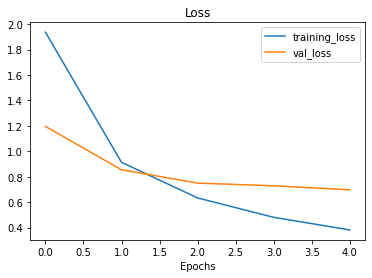

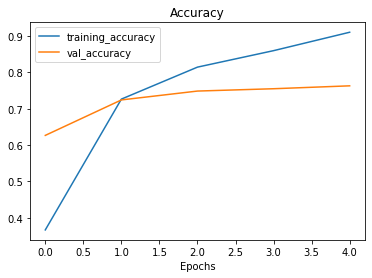

In [27]:
plot_loss_curves(resnet_history)

In [28]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# effientnet 으로 똑같은 방법으로 실습!

# 모델 생성
efficientnet_model = create_model(
    efficient_url,
    num_classes = train_data_10_percent.num_classes
)

# 컴파일
efficientnet_model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    callbacks = [
        create_tensorboard_callback(
            dir_name = "tensorflow_hub",
            experiment_name = "resnet50V2"
        )
    ]
)